# Demo of watermark attack

## Setup：We will be using TensorFlow 1.2 and Keras 2.0.4. Let’s begin:

In [22]:
import tensorflow as tf

In [23]:
mnist = tf.keras.datasets.mnist

In [24]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 15s 249us/sample - loss: 0.2204 - acc: 0.9351
Epoch 2/5
60000/60000 [==============================] - 15s 253us/sample - loss: 0.0957 - acc: 0.9704
Epoch 3/5
60000/60000 [==============================] - 15s 247us/sample - loss: 0.0695 - acc: 0.9788
Epoch 4/5
60000/60000 [==============================] - 15s 249us/sample - loss: 0.0527 - acc: 0.9829
Epoch 5/5
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0638 - acc: 0.9823


[0.06380309155439026, 0.9823]

In [26]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [27]:
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Loading the data：The dataset we’re going to use can be downloaded from Kaggle. 

In [28]:
df = pd.read_csv("/Users/cestdrama/Downloads/creditcard.csv")

## Exploration

In [29]:
df.shape

(284807, 31)

## 31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let’s check for missing values:

In [56]:
df.isnull().values.any()

False

## We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let’s look at the two types of transactions:

In [32]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [33]:
normal.shape

(284315, 31)

## How different are the amount of money used in different transaction classes?

In [34]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [35]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

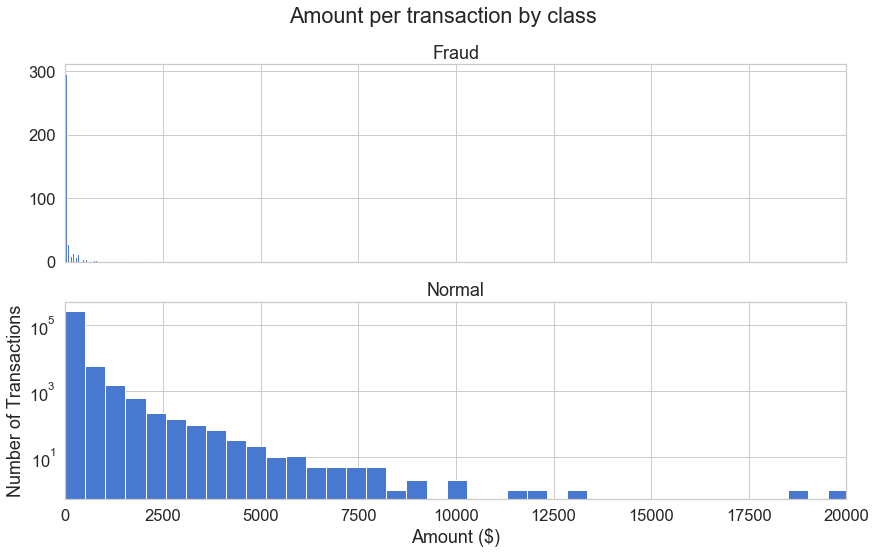

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

## Do fraudulent transactions occur more often during certain time?

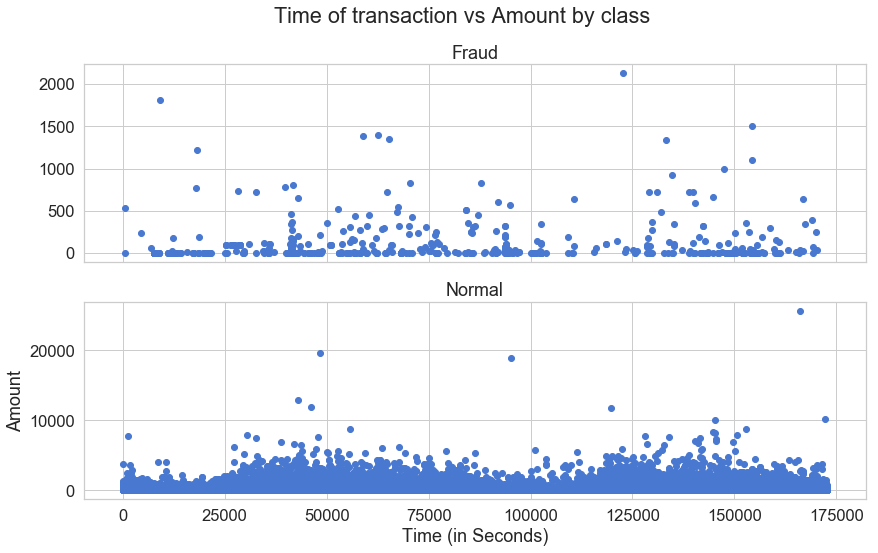

In [37]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Preparing the data：
### First, let’s drop the Time column (not going to use it) and use the scikit’s StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [38]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

###  We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [39]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

## Building the model

In [57]:
input_dim = X_train.shape[1]
print(X_train.shape[1])
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

29


In [41]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 10s 43us/step - loss: 0.8330 - acc: 0.5516 - val_loss: 0.8118 - val_acc: 0.6018
Epoch 2/100
227451/227451 [==============================] - 9s 42us/step - loss: 0.7722 - acc: 0.6181 - val_loss: 0.7932 - val_acc: 0.6265
Epoch 3/100
227451/227451 [==============================] - 10s 45us/step - loss: 0.7608 - acc: 0.6274 - val_loss: 0.7880 - val_acc: 0.6364
Epoch 4/100
227451/227451 [==============================] - 10s 44us/step - loss: 0.7563 - acc: 0.6329 - val_loss: 0.7833 - val_acc: 0.6401
Epoch 5/100
227451/227451 [==============================] - 10s 42us/step - loss: 0.7518 - acc: 0.6371 - val_loss: 0.7824 - val_acc: 0.6428
Epoch 6/100
227451/227451 [==============================] - 10s 44us/step - loss: 0.7497 - acc: 0.6395 - val_loss: 0.7793 - val_acc: 0.6360
Epoch 7/100
227451/227451 [=============================

### And load the saved model (just to check if it works):

In [42]:
autoencoder = load_model('model.h5')

## Evaluation

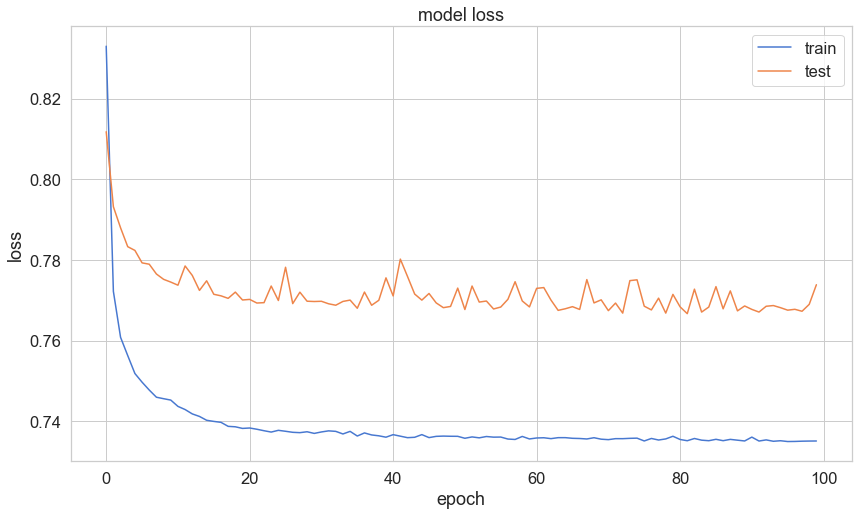

In [43]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Error distribution

In [44]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.758476,0.001720
std,3.360180,0.041443
min,0.043669,0.000000
25%,0.246245,0.000000
50%,0.409334,0.000000
75%,0.679738,0.000000
max,263.468204,1.000000


## Reconstruction error without fraud

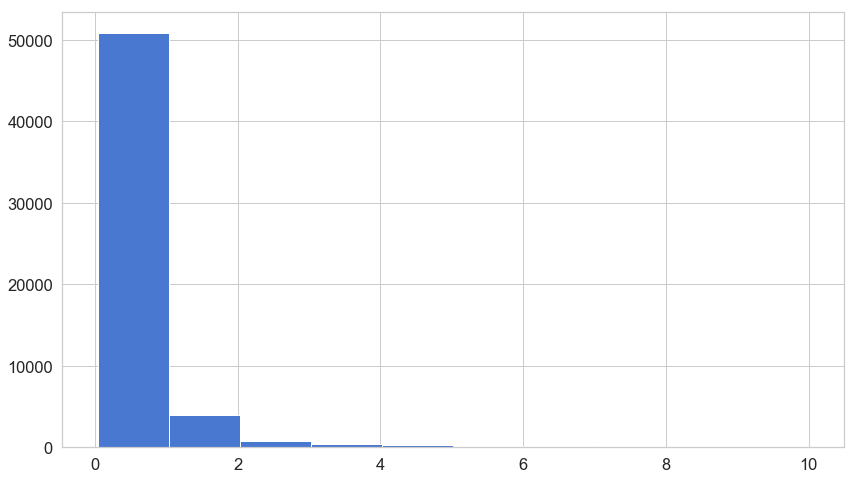

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

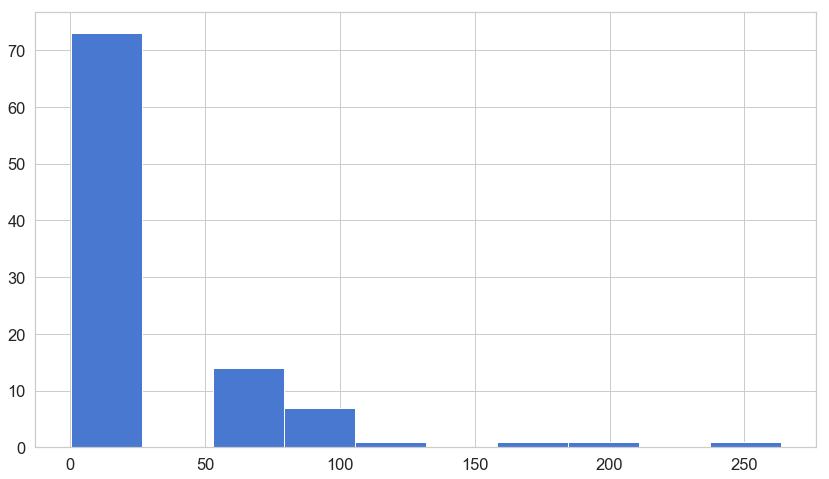

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

## ROC curve

In [47]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

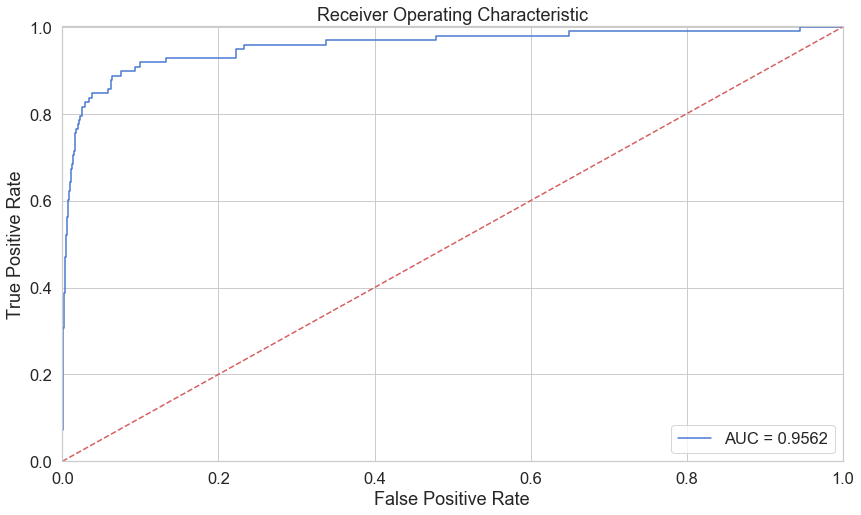

In [48]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

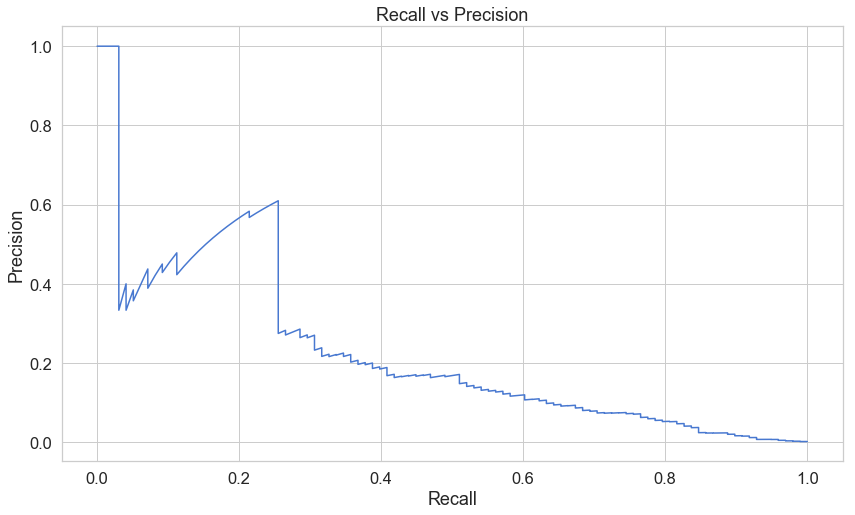

In [49]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

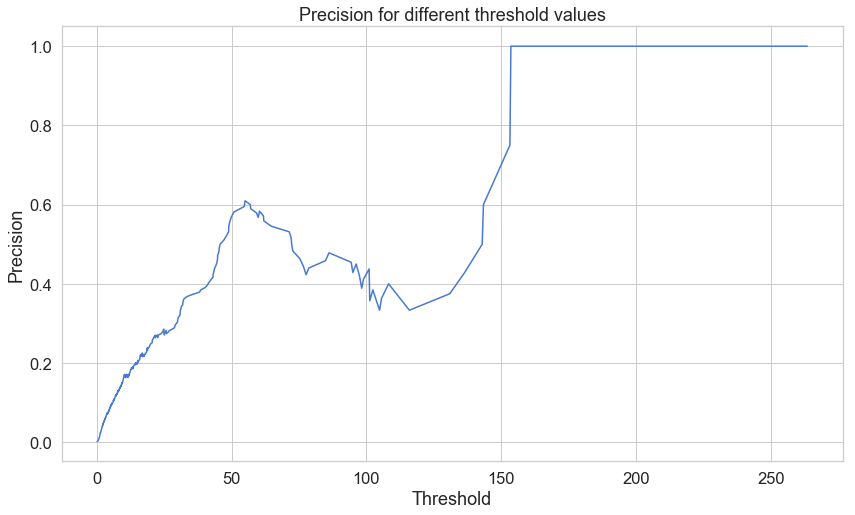

In [50]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

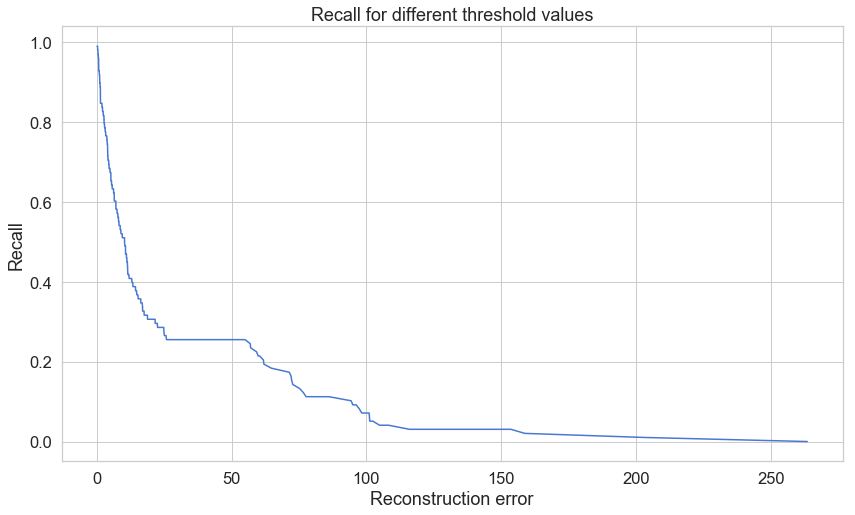

In [51]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## Prediction

In [52]:
threshold = 2.9

### see how well we’re dividing the two types of transactions:

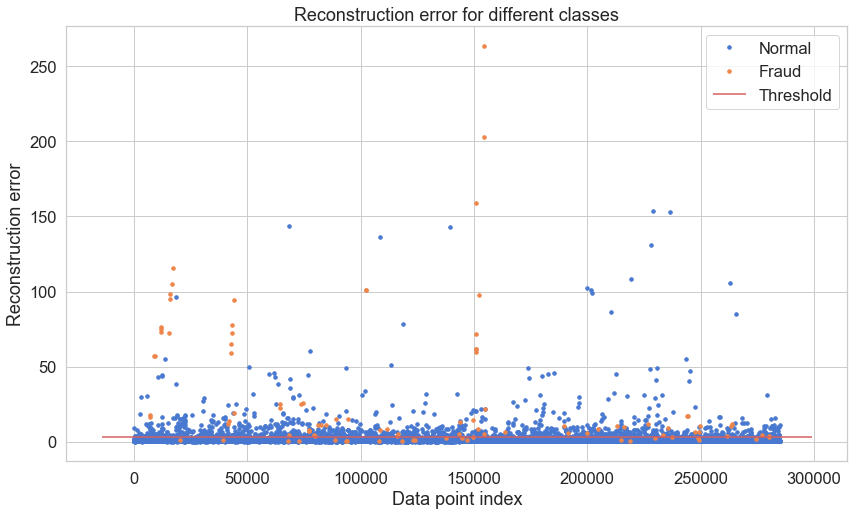

In [53]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### confusion matrix

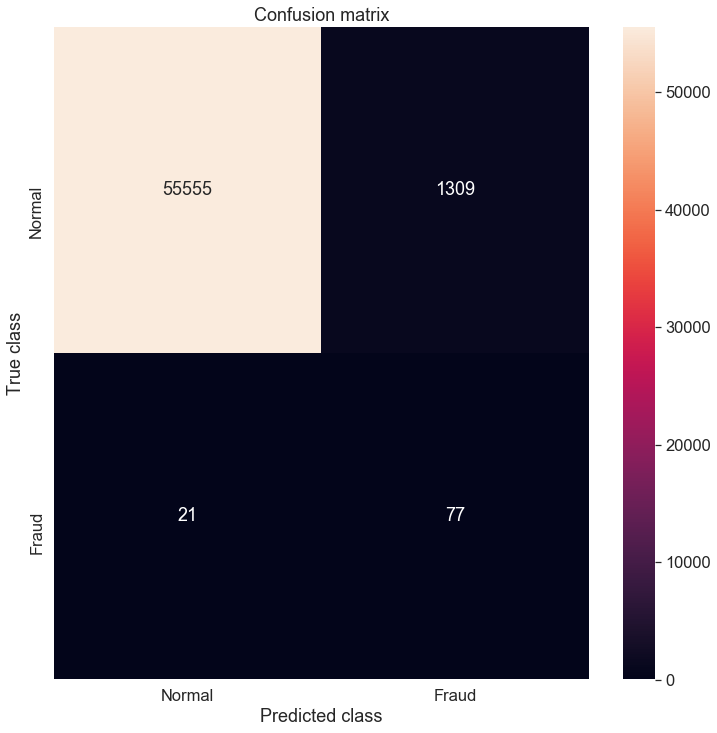

In [54]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
